# 单目标PV部署分区决策图

## 1、Load data

In [ ]:
import pandas as pd
from function import *
from function.global_varibles import *
import geopandas as gpd
from shapely.geometry import Point

df_economic_feasibility=pd.read_csv(PATHS['df_economic_feasibility'])
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')



#这里把生成的数据预处理了一下，新计算的数据
def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
    """
    Clip a dataframe using US states shapefile
    """
    # Create geometry points from coordinates
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # Ensure US states has the same CRS
    us_states_4326 = us_states.to_crs('EPSG:4326')
    
    # Perform spatial join to find points within US states
    clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    
    # Remove geometry columns and keep original data
    clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
    
    # Remove any additional columns from the shapefile that might have been added
    shapefile_columns = us_states.columns.tolist()
    for col in shapefile_columns:
        if col in clipped_df.columns:
            clipped_df = clipped_df.drop(columns=[col])
    
    return clipped_df

# df_economic_feasibility=clip_data_with_us_states(df_economic_feasibility)
# df_economic_feasibility.to_csv('data/US_data/df_economic.csv', index=False)





gogogo


In [3]:
df_economic_feasibility

Empty DataFrame
Columns: [lat, lon, pv_category, pv_model, pv_scenario, policy_category, rcp_category, net_npv_usd, net_cost_usd, net_npv_usd_demand, analysis_year]
Index: []

In [4]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np



# Function to clip dataframes using the US states shapefile
def clip_data_with_us_states(df, lon_col='lon', lat_col='lat'):
    """
    Clip a dataframe using US states shapefile
    """
    # Create geometry points from coordinates
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    
    # Ensure US states has the same CRS
    us_states_4326 = us_states.to_crs('EPSG:4326')
    
    # Perform spatial join to find points within US states
    clipped_gdf = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    
    # Remove geometry columns and keep original data
    clipped_df = clipped_gdf.drop(columns=['geometry', 'index_right'])
    
    # Remove any additional columns from the shapefile that might have been added
    shapefile_columns = us_states.columns.tolist()
    for col in shapefile_columns:
        if col in clipped_df.columns:
            clipped_df = clipped_df.drop(columns=[col])
    
    return clipped_df

# # Clip all your dataframes
# df_economic = clip_data_with_us_states(df_economic)
# df_weight = clip_data_with_us_states(df_weight)
# df_strategies = clip_data_with_us_states(df_strategies)
# df_net_benefit = clip_data_with_us_states(df_net_benefit)
# df_pv_npv = clip_data_with_us_states(df_pv_npv)
# df_agricultural_npv = clip_data_with_us_states(df_agricultural_npv)
# df_afforestation_npv = clip_data_with_us_states(df_afforestation_npv)
# df_natural_npv = clip_data_with_us_states(df_natural_npv)

df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_weight = pd.read_csv('data/US_data/df_weight.csv')
df_strategies = pd.read_csv('data/US_data/df_strategies.csv')
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')
df_pv_npv = pd.read_csv('data/US_data/df_pv_npv.csv')
df_agricultural_npv = pd.read_csv('data/US_data/df_agricultural_npv.csv')
df_afforestation_npv = pd.read_csv('data/US_data/df_afforestation_npv.csv')
df_natural_npv = pd.read_csv('data/US_data/df_natural_npv.csv')
df_gmm_scores = pd.read_csv('data/US_data/df_gmm_scores.csv')
df_pixel_optimized_data = pd.read_csv('data/US_data/df_pixel_optimized_data.csv')


# df_weight = df_weight.merge(
#     df_gmm_scores[['lat', 'lon', 'gmm_score', 'gmm_density','predicted_label','predicted_prob','sample_type']],
#     on=['lat', 'lon'],
#     how='left'
# )
# df_weight.to_csv('data/US_data/df_weight.csv', index=False)









In [12]:



def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

You want to predict the year: 2020.0
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值
列 GDPpc 没有需要填充的非正值或NaN值
列 GURdist 没有需要填充的非正值或NaN值


## 2、地图绘图模块

### 2.1 单维度决策图汇总

In [5]:

# 环境维度的变量
env_data = df_weight[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# 碳减排维度的变量
emission_data = df_weight[['lat', 'lon', 'Expectation_net_benefit']].copy()

# 经济维度的变量
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index()

# 合并所有变量
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')


                      

In [6]:
merged_data_for_plot

lat         lon  predicted_prob   gmm_density      sample_type  \
0      25.295834  -80.287500        0.000000  3.874315e+16  negative_sample   
1      25.437500  -80.537500        0.002796  2.054387e+18       prediction   
2      25.437500  -80.495834        0.000000  4.247702e+15  negative_sample   
3      25.445833  -80.454170        0.000000  1.117299e+13  negative_sample   
4      25.445833  -80.404170        0.001190  4.463459e+17       prediction   
...          ...         ...             ...           ...              ...   
64977  48.995834 -111.970830        0.005805  1.493778e+17       prediction   
64978  48.995834 -110.345830        0.009486  4.120084e+17       prediction   
64979  48.995834 -106.020836        0.006799  3.232082e+17       prediction   
64980  48.995834 -104.087500        0.013564  6.627032e+21       prediction   
64981  48.995834 -104.079170        0.019500  6.469832e+18       prediction   

       Expectation_net_benefit    net_npv_usd  
0                  6382.303639  407275.912577  
1                  5690.624063  283953.326746  
2                  6055.300591  275019.106094  
3                  6048.645138  269947.631894  
4                  6081.010322  291620.314126  
...                        ...            ...  
64977              6210.923349 -220868.055076  
64978              6206.053157 -219393.096487  
64979              6204.952188 -205704.827949  
64980              6077.421747 -300314.323514  
64981              6083.031871 -294315.333974  

[64982 rows x 7 columns]

In [31]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. 读取DEM并设置CRS（如果缺失）
dem = rioxarray.open_rasterio(r'C:\Phd_art\Abandoned_land_pv\Data_all\DEM.nc', masked=True)

# 检查DEM的CRS，如果缺失则手动设置
if dem.rio.crs is None:
    # 根据DEM数据的坐标范围判断，通常全球DEM使用EPSG:4326
    print("DEM CRS缺失，设置为EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. 确保US nation的CRS与DEM一致
if us_nation.crs != dem.rio.crs:
    print(f"转换US nation CRS从 {us_nation.crs} 到 {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)



# 4. 用us_nation精确裁剪DEM
print("开始裁剪DEM（使用us_nation）...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEM裁剪完成！")





DEM CRS缺失，设置为EPSG:4326
转换US nation CRS从 EPSG:4269 到 EPSG:4326
开始裁剪DEM（使用us_nation）...
DEM裁剪完成！


C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:121: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:123: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)
C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tigh

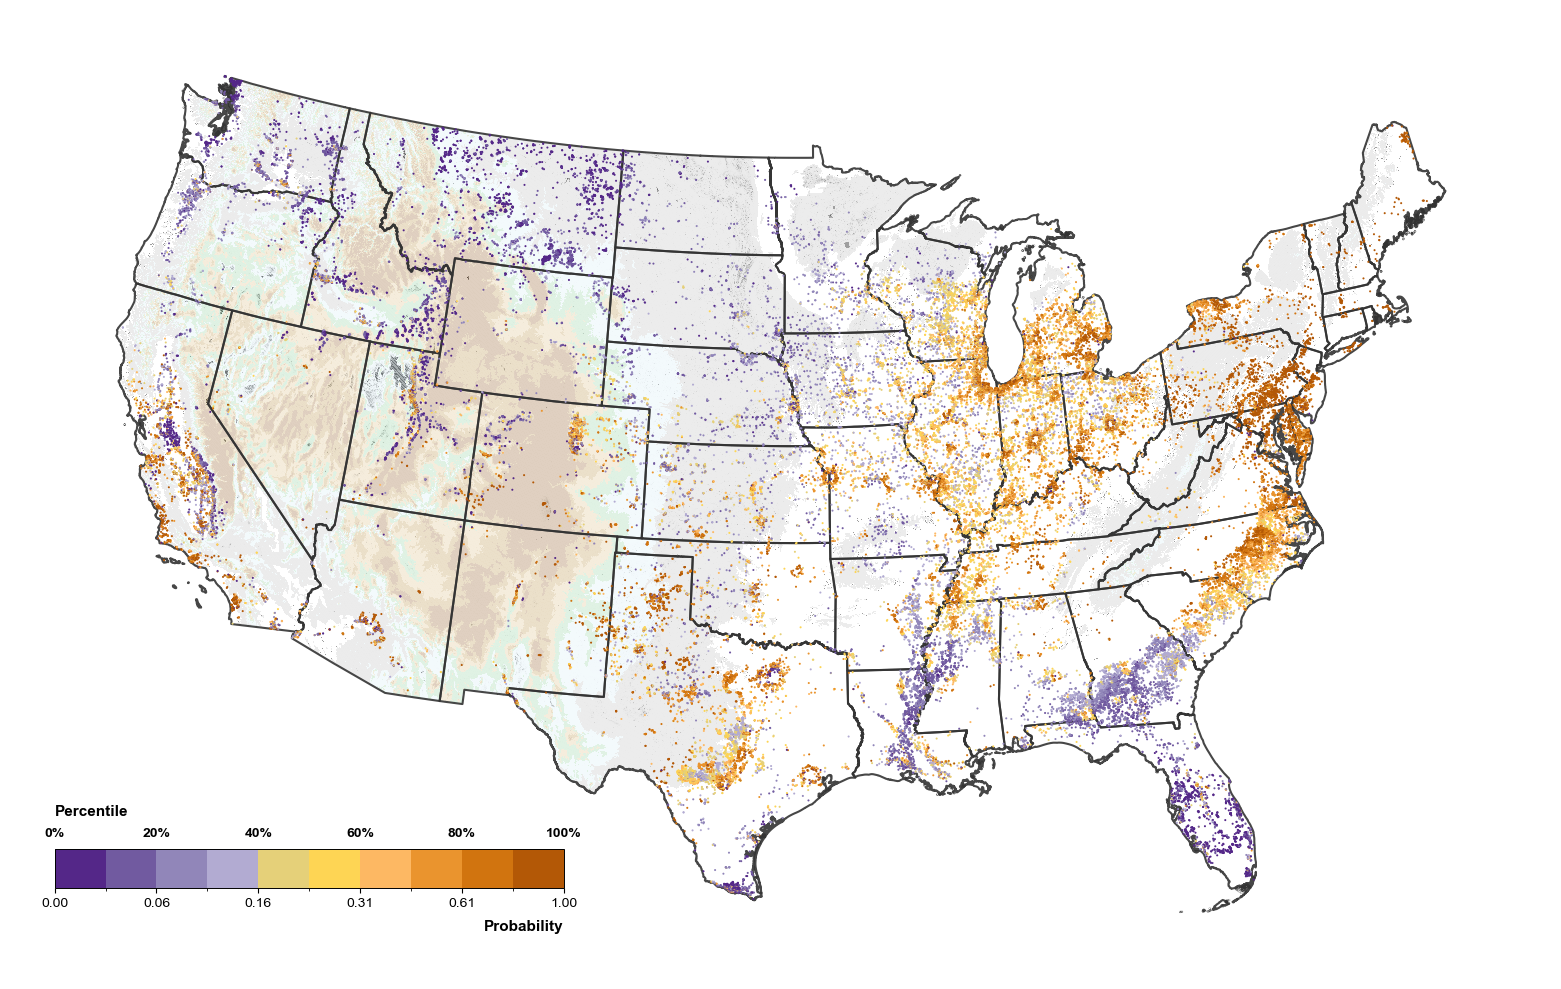

C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:121: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:123: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)
C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tigh

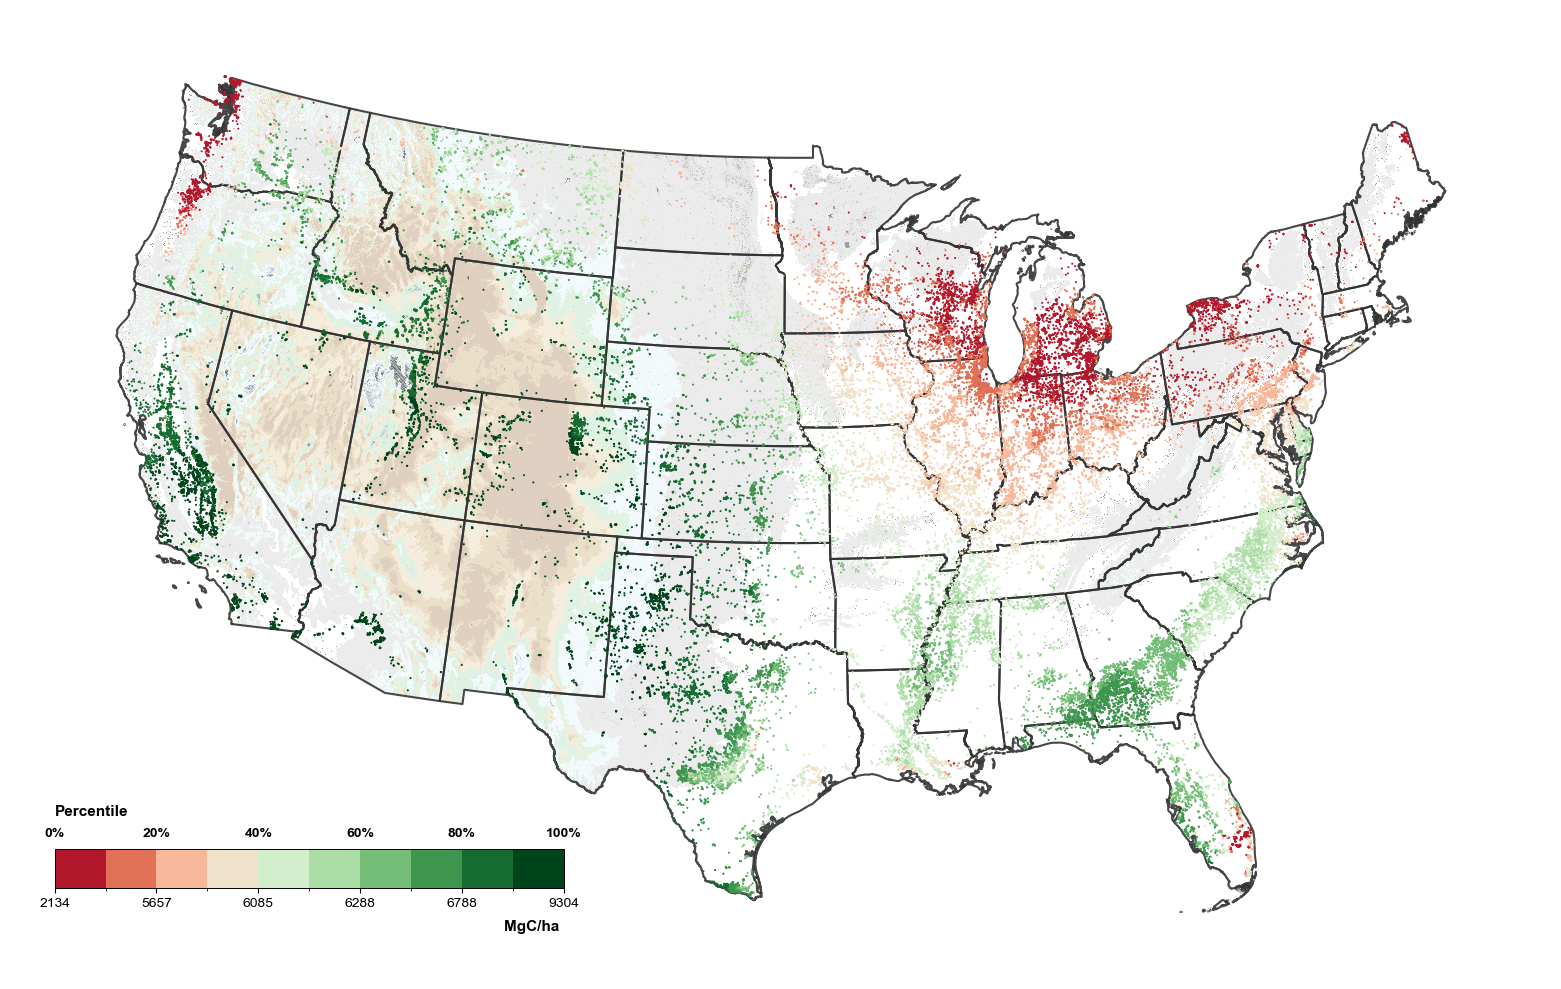

C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:121: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:123: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)
C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\4207883018.py:271: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tigh

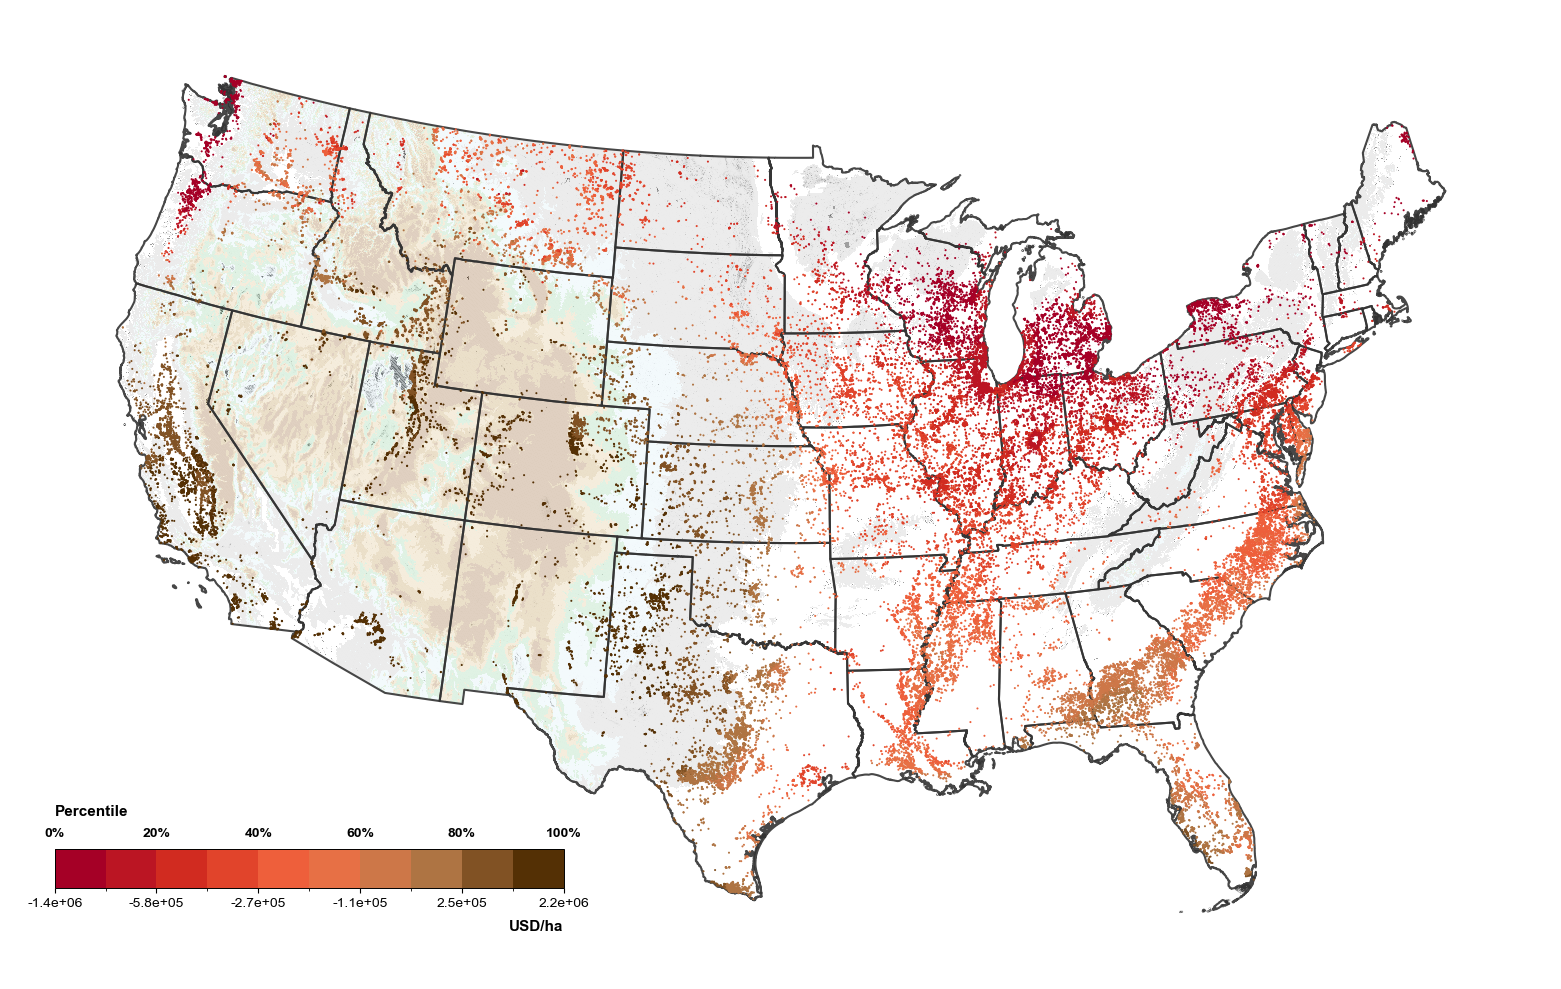

所有图片生成完成！


In [32]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_single_variable_nature_style(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    variable_name,
    title=None, 
    unit=None, 
    colors=None, 
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """

    参数:
        merged_data_for_plot: DataFrame，包含要绘制的数据，必须包含'lat'和'lon'列
        us_states_gdf: GeoDataFrame，美国各州边界
        dem_data: xarray.DataArray，DEM高程数据
        variable_name: str，要绘制的变量名
        title: str, 可选，图标题，默认为None
        unit: str, 可选，单位，默认为None
        colors: 颜色映射，默认为None
        cmap_type: str, 颜色映射类型，默认为'sequential'
        add_north_arrow_and_scalebar: bool, 是否添加指北针和比例尺
        add_embedding_points: bool, 是否绘制embedding点
    """
    
    # 设置字体为Arial
    plt.rcParams['font.family'] = 'Arial'
    
    # 创建单个图
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    
    # 去除地图最外的地图框线（spines）
    for spine in ax.spines.values():
        spine.set_visible(False)
        spine.set_edgecolor('none')
        spine.set_alpha(0)  # 保险起见，设置为透明

    # 美国边界设置
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    
    # 转换坐标
    x_proj, y_proj = transformer.transform(merged_data_for_plot['lon'].values, 
                                          merged_data_for_plot['lat'].values)
    
    # 转换embedding点坐标（如果需要）
    if add_embedding_points and (df_pv_embedding is not None):
        emb_x_proj, emb_y_proj = transformer.transform(df_pv_embedding['lon'].values, 
                                                      df_pv_embedding['lat'].values)
    
    def add_dem_hillshade(ax, dem_data, usa_bounds_main, transformer):
        """
        添加DEM底图和山体阴影（增强立体感和纹理感）
        参照 6.4 Figure0_economic_feasibility.ipynb 的写法，修正采样和投影问题
        """
        dem_lon = dem_data.x.values
        dem_lat = dem_data.y.values
        lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
        lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
        lon_indices = np.where(lon_mask)[0]
        lat_indices = np.where(lat_mask)[0]

        if len(lon_indices) > 0 and len(lat_indices) > 0:
            # 采样步长，防止点太多
            step = max(1, len(lon_indices) // 2000)
            lon_subset = lon_indices[::step]
            lat_subset = lat_indices[::step]
            elev_subset = dem_data.squeeze().values[np.ix_(lat_subset, lon_subset)]
            valid_mask = ~np.isnan(elev_subset)
            valid_elev = elev_subset[valid_mask]

            if valid_elev.size > 0:
                low_elev_threshold = np.percentile(valid_elev, 40)
                elev_masked = elev_subset.copy()
                elev_masked[elev_subset < low_elev_threshold] = np.nan
                valid_elev_masked = elev_masked[~np.isnan(elev_masked)]
                if valid_elev_masked.size > 0:
                    def generate_hillshade(elevation_array, azimuth=315, altitude=45):
                        elev_filled = np.where(np.isnan(elevation_array), 0, elevation_array)
                        dy, dx = np.gradient(elev_filled)
                        slope = np.arctan(np.sqrt(dx**2 + dy**2))
                        aspect = np.arctan2(-dx, dy)
                        azimuth_rad = np.radians(azimuth)
                        altitude_rad = np.radians(altitude)
                        hillshade = (np.sin(altitude_rad) * np.sin(slope) +
                                     np.cos(altitude_rad) * np.cos(slope) *
                                     np.cos(azimuth_rad - aspect))
                        hillshade = (hillshade + 1) / 2
                        hillshade[np.isnan(elevation_array)] = np.nan
                        return hillshade

                    # 多方向hillshade叠加，增强立体感
                    azimuths = [315, 45, 135, 225]
                    hillshades = [generate_hillshade(elev_masked, azimuth=a, altitude=45) for a in azimuths]
                    hillshade = np.mean(hillshades, axis=0)
                    terrain_colors = ListedColormap([
                        "#cccccc", "#e0f3fa", "#a8ddb5", "#e6cfa1", "#c9a86b", "#a97c50"
                    ])
                    percentiles = np.percentile(valid_elev_masked, [30, 45, 60, 70, 80, 90, 100])
                    norm = BoundaryNorm(percentiles, terrain_colors.N)
                    lon_grid, lat_grid = np.meshgrid(dem_lon[lon_subset], dem_lat[lat_subset])
                    dem_x_proj, dem_y_proj = transformer.transform(lon_grid.flatten(), lat_grid.flatten())
                    dem_x_proj = dem_x_proj.reshape(lon_grid.shape)
                    dem_y_proj = dem_y_proj.reshape(lat_grid.shape)
                    # 直接画，不做单调性检查
                    ax.pcolormesh(dem_x_proj, dem_y_proj, elev_masked, cmap=terrain_colors, norm=norm,
                                  alpha=0.5, zorder=1)
                    ax.pcolormesh(dem_x_proj, dem_y_proj, hillshade, cmap='gray', alpha=0.3, zorder=2)

    def add_nature_north_arrow(ax, size=0.04):
        """添加指北针"""
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0

        desired_size = 0.045
        h = desired_size * dy
        w = h * 0.5

        # 往左边靠一点，原来是0.965，改为0.93
        cx = x0 + 0.9 * dx
        cy = y0 + 0.945 * dy

        coords = [[cx, cy + h / 2], [cx - w / 2, cy - h / 2], [cx + w / 2, cy - h / 2]]
        ax.add_patch(mpatches.Polygon(coords, closed=True, facecolor="white", 
                                     edgecolor="black", lw=1.2, zorder=10))
        ax.add_patch(mpatches.Polygon([[cx, cy + h / 2], [cx, cy - h / 2], [cx + w / 2, cy - h / 2]],
                                     closed=True, facecolor="black", edgecolor="black", lw=1.2, zorder=11))
        ax.text(cx, cy - h * 1.0, 'N', ha='center', va='center',
               fontsize=15, fontweight='bold', color='black', zorder=12)

    def add_nature_scalebar(ax, length_km=1000):
        """添加比例尺"""
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0

        bar_x = x0 + 0.70*dx
        bar_y = y0 + 0.03*dy
        bar_height = 0.01*dy
        bar_length = length_km * 1000

        n_segments = 4
        seg_len = bar_length / n_segments
        for i in range(n_segments):
            color = "black" if i % 2 == 0 else "white"
            ax.add_patch(mpatches.Rectangle((bar_x + i*seg_len, bar_y),
                                          seg_len, bar_height,
                                          facecolor=color, edgecolor="black", lw=0.8))
        ax.text(bar_x + bar_length/2, bar_y - 0.008*dy,
               f"{length_km} km", ha="center", va="top",
               fontsize=10, fontweight="bold", color="black")

    # 设置背景色为白色
    ax.set_facecolor('white')
    
    # 添加DEM底图
    add_dem_hillshade(ax, dem_data, usa_bounds_main, transformer)
    
    # 获取变量数据
    var_values = merged_data_for_plot[variable_name].values
    
    # 创建配色方案 - 修复颜色映射问题
    # 使用10个百分位数区间，需要11个边界值，但colormap需要10个颜色
    var_bins = np.percentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    
    # 确保colormap有足够的颜色数量
    if len(colors) < len(var_bins) - 1:
        # 如果颜色不够，进行插值
        from matplotlib.colors import to_rgba
        n_needed = len(var_bins) - 1
        color_positions = np.linspace(0, 1, len(colors))
        new_positions = np.linspace(0, 1, n_needed)
        
        # 为RGB三个通道分别插值
        colors_rgba = [to_rgba(c) for c in colors]
        r_interp = np.interp(new_positions, color_positions, [c[0] for c in colors_rgba])
        g_interp = np.interp(new_positions, color_positions, [c[1] for c in colors_rgba])
        b_interp = np.interp(new_positions, color_positions, [c[2] for c in colors_rgba])
        
        interpolated_colors = [(r, g, b, 1.0) for r, g, b in zip(r_interp, g_interp, b_interp)]
        cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", interpolated_colors, N=n_needed)
    else:
        # 如果颜色够用，直接使用
        cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors[:len(var_bins)-1], N=len(var_bins)-1)
    
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    
    # 绘制散点图
    scatter = ax.scatter(x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
                       s=2.2, alpha=1.0, edgecolors='none', zorder=5)
    
    # 如果需要，绘制embedding点
    # if add_embedding_points and (df_pv_embedding is not None):
    #     # 以黑色小点形式叠加
    #     ax.scatter(emb_x_proj, emb_y_proj, s=8, c='black', marker='o', alpha=0.7, edgecolors='none', zorder=6, label='PV Embedding')
    
    # 设置地图边界
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds
    mx, my = (xmax - xmin) * 0.08, (ymax - ymin) * 0.08
    ax.set_xlim(xmin - mx, xmax + mx)
    ax.set_ylim(ymin - my, ymax + my)
    
    # 绘制州界
    us_states_albers.plot(ax=ax, color='none', edgecolor='#333333', linewidth=1.5, alpha=0.9, zorder=3)
    
    
    # 移除坐标轴
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    
    # 添加标题
    # ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # 添加颜色条（位置略上移）
    cbar_ax = inset_axes(ax, width="33%", height="4%",
                       loc='lower left',
                       bbox_to_anchor=(0.02, 0.08, 1, 1),  
                       bbox_transform=ax.transAxes, borderpad=1)
    cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
    cbar.set_ticks(var_bins[::2])
    
    # 格式化刻度标签
    if variable_name == 'net_npv_usd':
        # 使用科学计数法格式化
        tick_labels = [f'{v:.1e}' for v in var_bins[::2]]
    elif variable_name == 'predicted_prob':
        tick_labels = [f'{v:.2f}' for v in var_bins[::2]]
    else:
        tick_labels = [f'{v:.0f}' for v in var_bins[::2]]
        
    cbar.set_ticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=10)
    cbar.outline.set_linewidth(0.7)
    
    # 添加"Percentile"标签和单位标签
    cbar_ax.text(0, 1.8, "Percentile", ha='left', va='bottom', fontsize=11, 
                fontweight='bold', transform=cbar_ax.transAxes)

    # 添加百分位数标签
    percentile_labels = [f'{p}%' for p in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100][::2]]
    for i, label in enumerate(percentile_labels):
        cbar_ax.text(i / (len(percentile_labels) - 1), 1.25, label,
                     transform=cbar_ax.transAxes, ha='center', va='bottom',
                     fontsize=10, fontweight='bold')
    # 使unit标签与100%的百分数标签右对齐
    cbar_ax.text(1.0, -0.8, unit, ha='right', va='top', fontsize=11, 
                fontweight='bold', transform=cbar_ax.transAxes)

    # # 只在需要时添加指北针和比例尺
    # if add_north_arrow_and_scalebar:
    #     add_nature_north_arrow(ax, size=0.08)
    #     add_nature_scalebar(ax, length_km=1000)

    plt.tight_layout()
    return fig, ax

# 定义三个变量的参数
variables_config = [
    {
        'name': 'predicted_prob',
        'title': 'Environmental Potential',
        'unit': 'Probability',
        # 渐变色：深紫->紫->浅紫->黄->浅橙->橙->深橙
        # 参考图像色带，使用ColorBrewer的PuOr色带并将中间灰色改为黄色
        'colors': [
            '#542788',  # 深紫
            '#8073ac',  # 紫
            '#b2abd2',  # 浅紫
            '#ffe34d',  # 黄
            '#fdb863',  # 浅橙
            '#e08214',  # 橙
            '#b35806'   # 深橙
        ],
        'filename': 'environmental_potential'
    },
    {
        'name': 'Expectation_net_benefit', 
        'title': 'Carbon Mitigation Potential',
        'unit': 'MgC/ha ',
        # 渐变色：红 -> 绿色 -> 深绿色
        # 参考图像色带，红色到绿色中间过渡
        'colors': [
            '#b2182b',  # 深红
            '#ef8a62',  # 浅红
            '#fddbc7',  # 米色/浅红
            '#d9f0d3',  # 浅绿色
            '#a6dba0',  # 绿色
            '#5aae61',  # 深绿色
            '#1b7837',  # 更深绿色
            '#00441b'   # 极深绿色
        ],
        'filename': 'carbon_mitigation_potential'
    },
    {
        'name': 'net_npv_usd',
        'title': 'Economic Potential', 
        'unit': 'USD/ha',
        # 深红→深褐色渐变，突出经济潜力的高低
        'colors': [
            '#a50026',  # 深红
            '#d7301f',  # 红褐
            '#f46d43',  # 橙褐
            '#b97c4b',  # 棕褐
            '#543005',  # 深褐
        ],
        'filename': 'economic_potential'
    }
]

# 生成三个单独的图
for i, var_config in enumerate(variables_config):
    # print(f"正在生成 {var_config['title']} 图...")
    try:
        # 只有第一幅图添加指北针和比例尺，并叠加embedding点
        add_north_arrow_and_scalebar = (i == 0)
        # 暂时不添加embedding
        add_embedding_points = False
        fig, ax = plot_single_variable_nature_style(
            merged_data_for_plot, 
            us_states_4326, 
            dem_us,
            var_config['name'],
            var_config['title'],
            var_config['unit'],
            var_config['colors'],
            add_north_arrow_and_scalebar=add_north_arrow_and_scalebar,
            add_embedding_points=add_embedding_points
        )
        
        # 保存图片
        filename = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.png"
        fig.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        
        # 清理内存
        plt.close(fig)
        
    except Exception as e:
        print(e)
        continue

print("所有图片生成完成！")

### 2.2 训练样本

#### Load data and plot

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from functions import *

us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')



def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    使用美国州界 shapefile 剪裁点数据；兼容不同版本的 geopandas 参数名
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # 旧版本 geopandas 使用 op 参数
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # 清理 shapefile 附加字段
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

# ---------------------------
# 0) 基础地理范围与底图
# ---------------------------
usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
# ---------------------------
# 1) 读取数据
# ---------------------------
df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])

# 初步经纬度范围过滤
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# 第二次用州界矢量更精确裁剪
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) 缺失值填充 + 去重
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)

cannot access local variable 'np' where it is not associated with a value
图片生成完成！


C:\Users\zpy10\AppData\Local\Temp\ipykernel_55524\1344328543.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base_cmap = cm.get_cmap('YlOrRd')


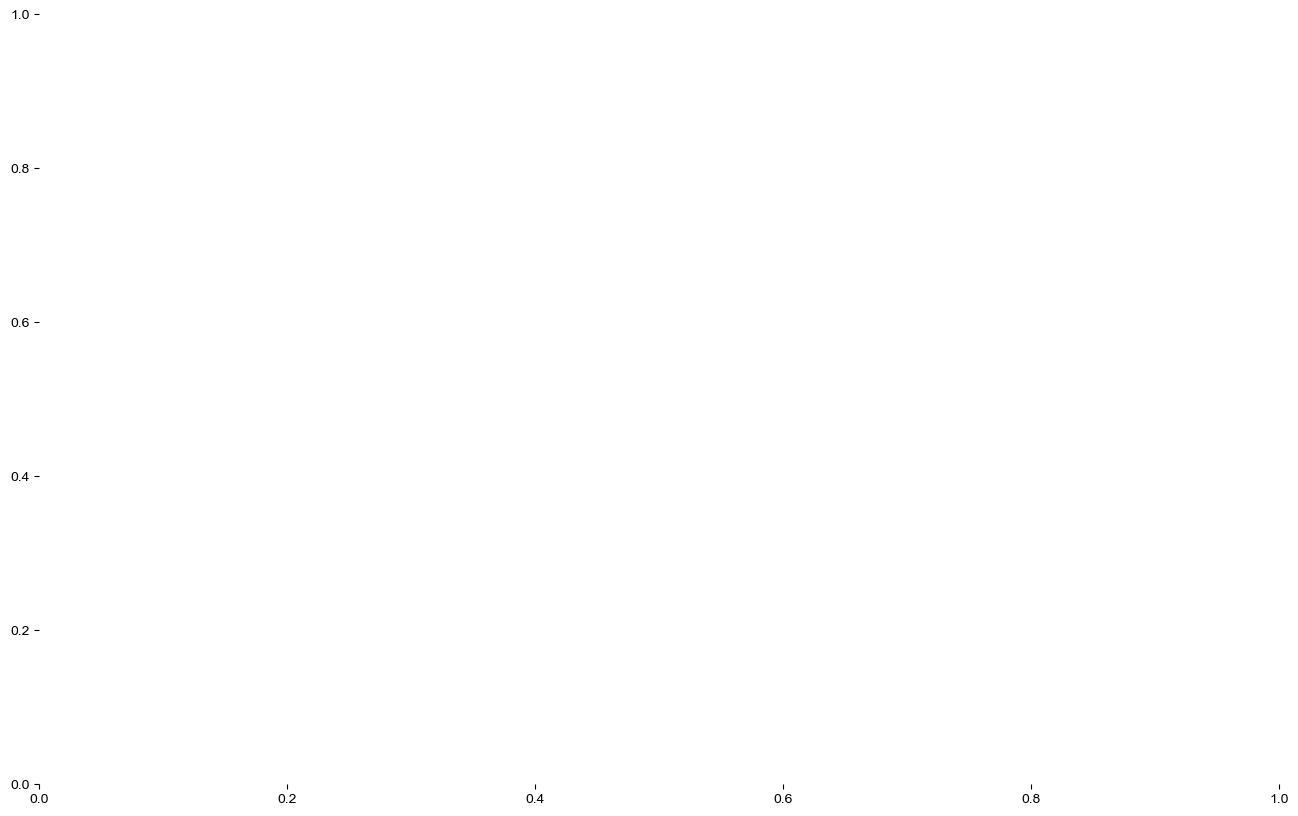

In [37]:
def plot_smaplesites_nature_style(
    df_abandon_filtered, 
    us_county_gdf, 
    df_pv_embedding,
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    参数:
        df_abandon_filtered: DataFrame，包含要绘制的撂荒点，必须包含'lat'和'lon'列
        us_county_gdf: GeoDataFrame，美国各县边界
        df_pv_embedding: DataFrame，包含要绘制的embedding数据，必须包含'lat'和'lon'列
        add_north_arrow_and_scalebar: bool, 是否添加指北针和比例尺
        add_embedding_points: bool, 是否绘制embedding点

        按照county_name聚合df_abandon_filtered数量，然后以淡色渐变绘制
        以气泡聚合的形式绘制df_pv_embedding的点
    """
    plt.rcParams['font.family'] = 'Arial'
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    for spine in ax.spines.values():
        spine.set_visible(False)
        spine.set_edgecolor('none')
        spine.set_alpha(0)
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_counties_bound = us_counties_4326.to_crs(epsg=4326).clip(bbox)
    us_counties_albers = us_counties_bound.to_crs('ESRI:102003')
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)

    # 补全：绘制df_abandon_filtered的点数量在county上的聚合
    # 1. 先将弃光点转为GeoDataFrame
    gdf_abandon = gpd.GeoDataFrame(
        df_abandon_filtered,
        geometry=gpd.points_from_xy(df_abandon_filtered['lon'], df_abandon_filtered['lat']),
        crs='EPSG:4326'
    )
    # 2. 投影到Albers
    gdf_abandon = gdf_abandon.to_crs('ESRI:102003')
    # 3. 空间连接到county，统计每个county的弃光点数量
    county_abandon_count = gpd.sjoin(
        gdf_abandon, us_counties_albers, how='left', predicate='within'
    ).groupby('index_right').size()
    # 4. 合并回county GeoDataFrame
    us_counties_albers['abandon_count'] = county_abandon_count
    us_counties_albers['abandon_count'] = us_counties_albers['abandon_count'].fillna(0)

    # 5. 绘制底图（county边界，弃光点数量用淡色渐变）
    # 创建自定义颜色映射：最低值用灰色，其他用YlOrRd
    from matplotlib.colors import LinearSegmentedColormap
    import matplotlib.colors as mcolors
    import matplotlib.cm as cm

    # 获取弃光点数量的统计信息
    min_count = us_counties_albers['abandon_count'].min()
    max_count = us_counties_albers['abandon_count'].max()
    
    # 创建自定义颜色映射：灰色到YlOrRd
    # 直接用matplotlib.cm.get_cmap获取YlOrRd
    base_cmap = cm.get_cmap('YlOrRd')
    colors = ['#D3D3D3'] + [base_cmap(x) for x in np.linspace(0.1, 1, 9)]  # 灰色 + YlOrRd的9个颜色
    custom_cmap = LinearSegmentedColormap.from_list('custom_gray_yellow_red', colors, N=256)
    
    # 设置颜色映射的边界
    norm = mcolors.Normalize(vmin=min_count, vmax=max_count)
    
    us_counties_albers.plot(
        ax=ax,
        column='abandon_count',
        cmap=custom_cmap,
        norm=norm,
        linewidth=0.8,
        edgecolor='#333333',
        alpha=0.8,
        zorder=2,
        legend=True,
        legend_kwds={
            'label': "Abandonment Count", 
            'shrink': 0.5,
            'orientation': 'vertical',
            'pad': 0.02
        }
    )

    # 6. 绘制弃光点（叠加小黑点，透明度低，避免遮挡）
    ax.scatter(
        gdf_abandon.geometry.x, gdf_abandon.geometry.y,
        s=8, c='black', alpha=0.1, marker='o', zorder=5, label='Abandonment Sites'
    )

    # 7. 绘制embedding点（气泡聚合形式）
    if add_embedding_points and (df_pv_embedding is not None):
        # 投影embedding点坐标
        emb_x_proj, emb_y_proj = transformer.transform(df_pv_embedding['lon'].values, 
                                                      df_pv_embedding['lat'].values)
        
        # 气泡聚合：使用更智能的聚类策略
        from sklearn.cluster import KMeans, DBSCAN
        from sklearn.preprocessing import StandardScaler
        import numpy as np
        
        # 根据10000个点的规模，设计更合理的聚类策略
        n_points = len(emb_x_proj)
        
        # 策略1：如果点太密集，先用DBSCAN进行空间聚类
        # 策略2：然后用K-means优化聚类中心
        # 策略3：根据地理密度动态调整聚类数量
        
        # 计算点的空间分布密度
        coords = np.column_stack([emb_x_proj, emb_y_proj])
        
        # 计算每个点到最近邻的距离，评估空间密度
        from sklearn.neighbors import NearestNeighbors
        nbrs = NearestNeighbors(n_neighbors=min(10, n_points//1000 + 1)).fit(coords)
        distances, _ = nbrs.kneighbors(coords)
        avg_distance = np.mean(distances[:, 1:])  # 排除自身距离
        
        # 根据空间密度动态确定聚类策略
        if avg_distance < 10000:  # 点很密集
            # 使用DBSCAN + K-means组合策略
            print(f"检测到高密度分布，使用DBSCAN+K-means组合聚类")
            
            # DBSCAN参数根据密度调整
            eps = max(5000, avg_distance * 2)  # 最小聚类半径
            min_samples = max(3, n_points // 10000)  # 最小聚类样本数
            
            # 先用DBSCAN进行初步空间聚类
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(coords)
            
            # 统计DBSCAN聚类结果
            n_dbscan_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
            noise_points = np.sum(dbscan_labels == -1)
            
            print(f"DBSCAN聚类结果: {n_dbscan_clusters}个聚类, {noise_points}个噪声点")
            
            # 如果DBSCAN聚类太少，用K-means补充
            if n_dbscan_clusters < 50:
                target_clusters = min(200, max(100, n_points // 50))
                print(f"DBSCAN聚类不足，使用K-means补充到{target_clusters}个聚类")
                
                # 标准化坐标
                scaler = StandardScaler()
                coords_scaled = scaler.fit_transform(coords)
                
                # K-means聚类
                kmeans = KMeans(n_clusters=target_clusters, random_state=42, n_init=10)
                kmeans_labels = kmeans.fit_predict(coords_scaled)
                
                # 使用K-means结果
                cluster_labels = kmeans_labels
                cluster_centers = kmeans.cluster_centers_
                cluster_centers = scaler.inverse_transform(cluster_centers)
                
            else:
                # 使用DBSCAN结果，计算聚类中心
                cluster_labels = dbscan_labels
                cluster_centers = []
                for label in sorted(set(dbscan_labels)):
                    if label != -1:  # 排除噪声点
                        mask = dbscan_labels == label
                        center = np.mean(coords[mask], axis=0)
                        cluster_centers.append(center)
                cluster_centers = np.array(cluster_centers)
                
        else:
            # 点相对稀疏，直接使用K-means
            print(f"检测到中等密度分布，使用K-means聚类")
            
            # 根据数据规模确定聚类数量
            if n_points > 5000:
                n_clusters = min(300, max(150, n_points // 30))  # 每30个点聚为1个
            else:
                n_clusters = min(200, max(100, n_points // 20))
            
            print(f"K-means聚类数量: {n_clusters}")
            
            # 标准化坐标
            scaler = StandardScaler()
            coords_scaled = scaler.fit_transform(coords)
            
            # K-means聚类
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(coords_scaled)
            
            # 计算聚类中心
            cluster_centers = kmeans.cluster_centers_
            cluster_centers = scaler.inverse_transform(cluster_centers)
        
        # 计算每个聚类的点数量和大小
        unique_labels, counts = np.unique(cluster_labels, return_counts=True)
        cluster_sizes = np.zeros(len(cluster_centers))
        
        # 映射标签到索引
        label_to_idx = {label: idx for idx, label in enumerate(unique_labels) if label != -1}
        
        for label, count in zip(unique_labels, counts):
            if label != -1:  # 排除DBSCAN的噪声点
                cluster_sizes[label_to_idx[label]] = count
        
        # 优化气泡大小计算
        # 使用对数缩放，避免大小差异过大
        max_size = 400  # 最大气泡大小
        min_size = 15   # 最小气泡大小
        
        # 对数归一化气泡大小
        if cluster_sizes.max() > cluster_sizes.min():
            # 使用对数缩放，让大小差异更合理
            log_sizes = np.log1p(cluster_sizes)  # log1p避免log(0)的问题
            normalized_sizes = min_size + (max_size - min_size) * (log_sizes - log_sizes.min()) / (log_sizes.max() - log_sizes.min())
        else:
            normalized_sizes = np.full_like(cluster_sizes, (min_size + max_size) / 2)
        
        # 绘制气泡，使用渐变色表示密度
        # 根据聚类大小选择颜色
        colors = plt.cm.Blues(normalized_sizes / max_size)
        
        # 绘制气泡
        scatter = ax.scatter(
            cluster_centers[:, 0], cluster_centers[:, 1],
            s=normalized_sizes, 
            c=colors, 
            marker='o', 
            alpha=0.7, 
            edgecolors='white',
            linewidth=0.8,
            zorder=6, 
            label='PV Embedding (Clustered)'
        )
        
        # 添加图例说明
        print(f"Embedding点聚合完成: 原始{len(emb_x_proj)}个点 → {len(cluster_centers)}个气泡")
        print(f"气泡大小范围: {normalized_sizes.min():.1f} - {normalized_sizes.max():.1f} 像素")
        print(f"聚类大小分布: 最小{cluster_sizes.min():.0f}个点, 最大{cluster_sizes.max():.0f}个点")

    # 设置地图边界
    xmin, ymin, xmax, ymax = us_counties_albers.total_bounds
    mx, my = (xmax - xmin) * 0.08, (ymax - ymin) * 0.08
    ax.set_xlim(xmin - mx, xmax + mx)
    ax.set_ylim(ymin - my, ymax + my)

    # 再绘制州界线（覆盖在上面，增强边界感）
    us_counties_albers.boundary.plot(ax=ax, color='#333333', linewidth=1.5, alpha=0.9, zorder=10)

    # 移除坐标轴
    ax.set_xticks([])
    ax.set_yticks([])
    ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    ax.set_facecolor('white')

    # 指北针和比例尺
    def add_nature_north_arrow(ax, size=0.04):
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0
        desired_size = 0.045
        h = desired_size * dy
        w = h * 0.5
        cx = x0 + 0.9 * dx
        cy = y0 + 0.945 * dy
        coords = [[cx, cy + h / 2], [cx - w / 2, cy - h / 2], [cx + w / 2, cy - h / 2]]
        ax.add_patch(mpatches.Polygon(coords, closed=True, facecolor="white", 
                                     edgecolor="black", lw=1.2, zorder=20))
        ax.add_patch(mpatches.Polygon([[cx, cy + h / 2], [cx, cy - h / 2], [cx + w / 2, cy - h / 2]],
                                     closed=True, facecolor="black", edgecolor="black", lw=1.2, zorder=21))
        ax.text(cx, cy - h * 1.0, 'N', ha='center', va='center',
               fontsize=15, fontweight='bold', color='black', zorder=22)

    def add_nature_scalebar(ax, length_km=1000):
        x0, x1 = ax.get_xlim()
        y0, y1 = ax.get_ylim()
        dx, dy = x1 - x0, y1 - y0
        bar_x = x0 + 0.70*dx
        bar_y = y0 + 0.03*dy
        bar_height = 0.01*dy
        bar_length = length_km * 1000
        n_segments = 4
        seg_len = bar_length / n_segments
        for i in range(n_segments):
            color = "black" if i % 2 == 0 else "white"
            ax.add_patch(mpatches.Rectangle((bar_x + i*seg_len, bar_y),
                                          seg_len, bar_height,
                                          facecolor=color, edgecolor="black", lw=0.8, zorder=30))
        ax.text(bar_x + bar_length/2, bar_y - 0.008*dy,
               f"{length_km} km", ha="center", va="top",
               fontsize=10, fontweight="bold", color="black", zorder=31)

    if add_north_arrow_and_scalebar:
        add_nature_north_arrow(ax, size=0.08)
        add_nature_scalebar(ax, length_km=1000)

    plt.tight_layout()
    return fig, ax

# 只生成一个图，并重命名文件
try:
    fig, ax = plot_smaplesites_nature_style(
        df_abandon_filtered, 
        us_counties_4326, 
        df_embedding_fill,
        add_north_arrow_and_scalebar=True,
        add_embedding_points=False
    )
    filename = "figure/US_figure/machinelearning_map_300dpi.png"
    fig.savefig(filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    plt.close(fig)
except Exception as e:
    print(e)

print("图片生成完成！")


In [34]:
df_abandon_filtered 

Unnamed: 0       time        lat         lon  abandonment_year  \
0         1897288 2020-01-01  31.320833 -105.929170            2014.0   
1         1899788 2020-01-01  31.329166 -105.929170            2014.0   
2         1902287 2020-01-01  31.337500 -105.937500            2014.0   
3         1902288 2020-01-01  31.337500 -105.929170            2014.0   
4         1904787 2020-01-01  31.345833 -105.937500            2014.0   
...           ...        ...        ...         ...               ...   
64977    20192249 2020-01-01  46.937500  -67.920830            1998.0   
64978    20247244 2020-01-01  47.145832  -67.962500            2000.0   
64979    20271365 2020-01-01  47.237500  -68.620834            2000.0   
64980    20275797 2020-01-01  47.254166  -68.354164            2000.0   
64981    20277994 2020-01-01  47.262500  -68.379166            1997.0   

       abandonment_duration  current_abandonment  landcover        DEM  \
0                      10.0                    1        2.0  1074.1250   
1                      10.0                    1        3.0  1074.8125   
2                      10.0                    1        3.0  1075.3750   
3                      10.0                    1        2.0  1074.9375   
4                      10.0                    1        2.0  1075.9375   
...                     ...                  ...        ...        ...   
64977                  26.0                    1        2.0   199.3750   
64978                  24.0                    1        2.0   223.0000   
64979                  24.0                    1        2.0   181.2500   
64980                  24.0                    1        2.0   244.9375   
64981                  27.0                    1        2.0   269.7500   

         GDPpc  ...  Population  Powerdist  PrimaryRoad  SecondaryRoad  \
0      19547.0  ...    1.104119  622567.20    22.570979      20.346911   
1      19547.0  ...    1.104119  622567.20    22.570979      20.346911   
2      32645.0  ...    0.399327  622567.20    22.570979      20.346911   
3      32645.0  ...    3.593287  622567.20    22.570979      20.346911   
4      32645.0  ...    5.603361  622567.20    22.570979      20.346911   
...        ...  ...         ...        ...          ...            ...   
64977  33949.0  ...  218.050890  622564.50     4.273278      14.490743   
64978  33949.0  ...    9.665760  622564.30    32.119901      14.490743   
64979  33949.0  ...  141.555110  622564.00     3.471587      33.915221   
64980  33949.0  ...   17.156588  622564.06     8.030265       0.061349   
64981  33949.0  ...    5.105907  622564.06    49.859261       1.558921   

          Slope  TertiaryRoad       gdmp       rsds          tas      wind  
0      0.161280    109.755022  60.677334  21.335989  2934.915273  2.750262  
1      0.142680    109.755022  45.031578  21.334290  2934.829175  2.751782  
2      0.151240    109.755022  38.084999  21.337654  2934.583333  2.752204  
3      0.134330    109.755022  26.303532  21.336290  2934.584702  2.758872  
4      0.182301    109.755022  39.406666  21.343910  2934.581940  2.771071  
...         ...           ...        ...        ...          ...       ...  
64977  1.000655    129.836817  74.197998  12.735363  2768.901404  3.429452  
64978  3.852393     92.798418  73.082001  12.262959  2766.375025  3.813229  
64979  1.910013     80.651057  54.858932  12.550031  2768.493367  3.047965  
64980  1.939035     91.262543  74.170227  12.486876  2765.084545  4.128394  
64981  4.100901    150.075090  69.684128  12.318412  2763.957254  3.005180  

[64982 rows x 22 columns]

## 3.1 图1回归图

In [35]:
merged_data_for_plot

lat         lon  predicted_prob   gmm_density      sample_type  \
0      25.295834  -80.287500        0.000000  3.874315e+16  negative_sample   
1      25.437500  -80.537500        0.002796  2.054387e+18       prediction   
2      25.437500  -80.495834        0.000000  4.247702e+15  negative_sample   
3      25.445833  -80.454170        0.000000  1.117299e+13  negative_sample   
4      25.445833  -80.404170        0.001190  4.463459e+17       prediction   
...          ...         ...             ...           ...              ...   
64977  48.995834 -111.970830        0.005805  1.493778e+17       prediction   
64978  48.995834 -110.345830        0.009486  4.120084e+17       prediction   
64979  48.995834 -106.020836        0.006799  3.232082e+17       prediction   
64980  48.995834 -104.087500        0.013564  6.627032e+21       prediction   
64981  48.995834 -104.079170        0.019500  6.469832e+18       prediction   

       Expectation_net_benefit    net_npv_usd  
0                  6382.303639  407275.912577  
1                  5690.624063  283953.326746  
2                  6055.300591  275019.106094  
3                  6048.645138  269947.631894  
4                  6081.010322  291620.314126  
...                        ...            ...  
64977              6210.923349 -220868.055076  
64978              6206.053157 -219393.096487  
64979              6204.952188 -205704.827949  
64980              6077.421747 -300314.323514  
64981              6083.031871 -294315.333974  

[64982 rows x 7 columns]

原始数据量: 64982
过滤后数据量: 62444
有效数据点: 62444
GMM density 原始范围: 8.62e-45 - 1.37e+28
Log(GMM density) 范围: -101.46 - 64.79


C:\Users\zpy10\AppData\Local\Temp\ipykernel_59128\785822612.py:290: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


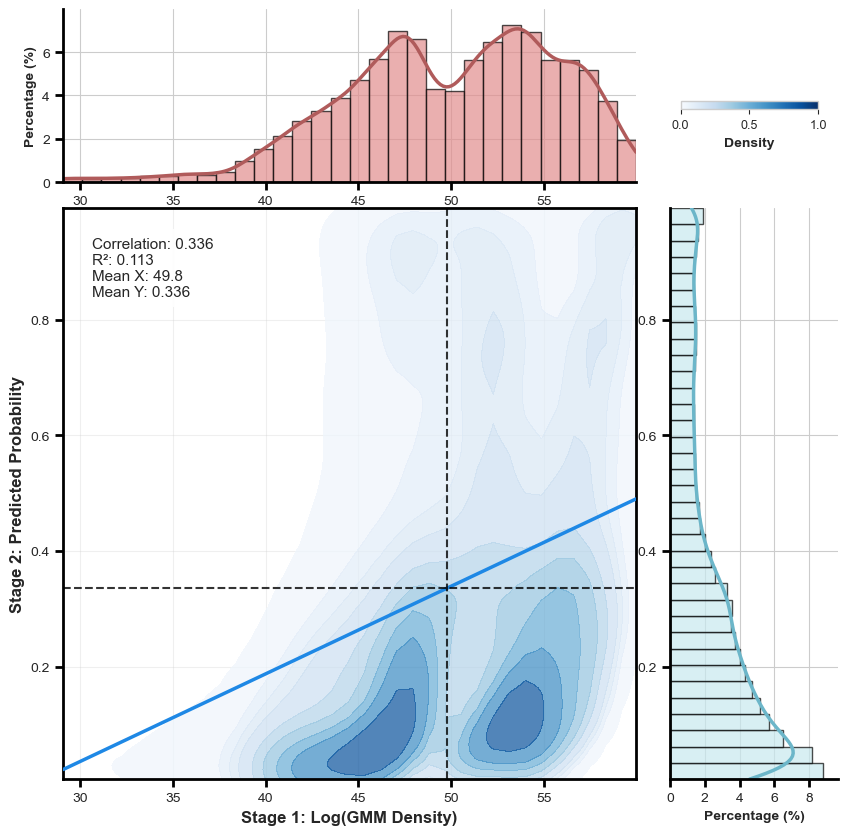

最终优化的联合分布图生成完成！


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def create_joint_distribution_plot_final(merged_data_for_plot):
    """
    创建最终优化的双变量联合分布图
    新增功能：
    1. 增加边际分布和联合分布之间的空隙
    2. 优化右侧边际分布的刻度标签显示
    """
    
    # 设置字体和风格
    plt.rcParams['font.family'] = 'Arial'
    sns.set_style("whitegrid")
    
    # 数据预处理：剔除negative_sample
    filtered_data = merged_data_for_plot[merged_data_for_plot['sample_type'] != 'negative_sample'].copy()
    
    print(f"原始数据量: {len(merged_data_for_plot)}")
    print(f"过滤后数据量: {len(filtered_data)}")
    
    # 创建图形布局 - 增加空隙
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 4, figure=fig, hspace=0.15, wspace=0.20)  
    
    # 主要的联合分布图
    ax_joint = fig.add_subplot(gs[1:4, 0:3])
    
    # 顶部边际分布（x轴）
    ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_joint)
    
    # 右侧边际分布（y轴）
    ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_joint)
    
    # 隐藏子图的标签
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    # 获取原始数据
    original_x_data = filtered_data['gmm_density'].values
    y_data = filtered_data['predicted_prob'].values
    
    # 移除NaN值和非正值（对于对数变换）
    mask = ~(np.isnan(original_x_data) | np.isnan(y_data)) & (original_x_data > 0)
    original_x_data = original_x_data[mask]
    y_data = y_data[mask]
    
    # 对GMM density进行对数变换
    x_data = np.log(original_x_data)  
    
    print(f"有效数据点: {len(x_data)}")
    print(f"GMM density 原始范围: {original_x_data.min():.2e} - {original_x_data.max():.2e}")
    print(f"Log(GMM density) 范围: {x_data.min():.2f} - {x_data.max():.2f}")
    
    # 计算均值和统计信息
    x_mean = np.mean(x_data)
    y_mean = np.mean(y_data)
    correlation = np.corrcoef(x_data, y_data)[0, 1]
    
    # 设置数据范围
    x_range = (np.percentile(x_data, 1), np.percentile(x_data, 99))
    y_range = (np.percentile(y_data, 1), np.percentile(y_data, 99))
    
    # 创建包含对数变换数据的临时DataFrame用于seaborn
    temp_df = pd.DataFrame({
        'log_gmm_density': x_data,
        'predicted_prob': y_data
    })
    
    # 1. 绘制联合分布（只保留KDE密度图，移除散点）
    kde_plot = None
    try:
        kde_plot = sns.kdeplot(data=temp_df, x="log_gmm_density", y="predicted_prob", 
                              cmap="Blues", fill=True, ax=ax_joint, alpha=0.7, zorder=2)
    except Exception as e:
        print(f"KDE绘制警告: {e}")
    
    # 添加颜色条到右上角
    try:
        norm1 = plt.Normalize(vmin=0, vmax=1)
        sm1 = plt.cm.ScalarMappable(cmap="Blues", norm=norm1)
        sm1.set_array([])
        
        # 创建颜色条的插入轴，bbox_to_anchor的第一个参数从0.98改为0.88
        axins1 = inset_axes(ax_joint, width="60%", height="15%",
                           bbox_to_anchor=(0.93, 1.1, 0.4, 0.1), 
                           bbox_transform=ax_joint.transAxes)
        
        cbar = plt.colorbar(sm1, cax=axins1, orientation='horizontal')
        cbar.set_label('Density', fontsize=10, fontweight='bold')
        cbar.ax.tick_params(labelsize=9)
        cbar.outline.set_linewidth(1)
        
    except Exception as e:
        print(f"颜色条绘制警告: {e}")
    
    # 添加回归线（使用指定颜色 #1E88E5）
    r_squared = None
    try:
        from sklearn.linear_model import LinearRegression
        
        # 重塑数据用于回归
        X = x_data.reshape(-1, 1)
        y = y_data
        
        # 线性回归
        reg = LinearRegression()
        reg.fit(X, y)
        r_squared = reg.score(X, y)
        
        # 生成回归线数据
        x_line = np.linspace(x_range[0], x_range[1], 100)
        y_line = reg.predict(x_line.reshape(-1, 1))
        
        ax_joint.plot(x_line, y_line, color='#1E88E5', linewidth=2.5, zorder=3)
        
    except Exception as e:
        print(f"回归线绘制警告: {e}")
    
    # 添加均值线（黑色细虚线）
    ax_joint.axvline(x=x_mean, color='black', linestyle='--', linewidth=1.5, 
                    alpha=0.8, zorder=4)
    ax_joint.axhline(y=y_mean, color='black', linestyle='--', linewidth=1.5, 
                    alpha=0.8, zorder=4)
    
    # 2. 绘制顶部边际分布（使用#E28D8D，bin外框线用黑色细线）
    n_bins_x = 30
    x_bins = np.linspace(x_range[0], x_range[1], n_bins_x + 1)
    
    # 绘制直方图（百分比）
    counts_x, bins_x, patches_x = ax_histx.hist(x_data, bins=x_bins, 
                                               color='#E28D8D', edgecolor='black', 
                                               alpha=0.7, density=False, linewidth=1)
    
    # 转换为百分比
    total_samples = len(x_data)
    percentages_x = (counts_x / total_samples) * 100
    
    # 清除原直方图，重新绘制百分比直方图
    ax_histx.clear()
    bars_x = ax_histx.bar(bins_x[:-1], percentages_x, width=np.diff(bins_x), 
                color='#E28D8D', edgecolor='black', alpha=0.7, align='edge', linewidth=1)
    
    # 添加拟合的分布曲线（#E28D8D深色）
    try:
        from scipy.stats import gaussian_kde
        kde_x = gaussian_kde(x_data)
        x_plot = np.linspace(x_range[0], x_range[1], 200)
        density_x = kde_x(x_plot)
        
        # 将密度转换为百分比尺度
        bin_width = np.diff(bins_x)[0]
        density_x_percent = density_x * bin_width * 100
        
        ax_histx.plot(x_plot, density_x_percent, color='#B05B5B', linewidth=2.5)
    except Exception as e:
        print(f"X轴密度曲线警告: {e}")
    
    # 3. 绘制右侧边际分布（使用#C8E9EF，bin外框线用黑色细线）
    n_bins_y = 35
    y_bins = np.linspace(y_range[0], y_range[1], n_bins_y + 1)
    
    # 绘制直方图（百分比）
    counts_y, bins_y, patches_y = ax_histy.hist(y_data, bins=y_bins,
                                               orientation='horizontal',
                                               color='#C8E9EF', edgecolor='black', 
                                               alpha=0.7, density=False, linewidth=1)
    
    # 转换为百分比
    percentages_y = (counts_y / total_samples) * 100
    
    # 清除原直方图，重新绘制百分比直方图
    ax_histy.clear()
    bars_y = ax_histy.barh(bins_y[:-1], percentages_y, height=np.diff(bins_y), 
                 color='#C8E9EF', edgecolor='black', alpha=0.7, align='edge', linewidth=1)
    
    # 添加拟合的分布曲线（#C8E9EF深色）
    try:
        kde_y = gaussian_kde(y_data)
        y_plot = np.linspace(y_range[0], y_range[1], 200)
        density_y = kde_y(y_plot)
        
        # 将密度转换为百分比尺度
        bin_height = np.diff(bins_y)[0]
        density_y_percent = density_y * bin_height * 100
        
        ax_histy.plot(density_y_percent, y_plot, color='#6CB6C9', linewidth=2.5)
    except Exception as e:
        print(f"Y轴密度曲线警告: {e}")
    
    # 4. 设置坐标轴范围和标签
    ax_joint.set_xlim(x_range)
    ax_joint.set_ylim(y_range)
    
    # 确保边际分布与主图对齐
    ax_histx.set_xlim(ax_joint.get_xlim())
    ax_histy.set_ylim(ax_joint.get_ylim())
    
    # 设置标签
    ax_joint.set_xlabel('Stage 1: Log(GMM Density)', fontsize=12, fontweight='bold')
    ax_joint.set_ylabel('Stage 2: Predicted Probability', fontsize=12, fontweight='bold')
    
    # 设置边际分布标签（现在显示）
    ax_histx.set_ylabel('Percentage (%)', fontsize=10, fontweight='bold')
    ax_histy.set_xlabel('Percentage (%)', fontsize=10, fontweight='bold')
    
    # 重新显示边际分布的刻度标签
    ax_histx.tick_params(axis="y", labelleft=True)
    ax_histy.tick_params(axis="x", labelbottom=True)
    
    # 添加网格
    ax_joint.grid(True, alpha=0.3)
    
    # 设置专业的坐标轴样式
    # 设置刻度线位置
    ax_joint.xaxis.set_ticks_position('bottom')
    ax_joint.yaxis.set_ticks_position('left')
    ax_histx.xaxis.set_ticks_position('bottom')
    ax_histx.yaxis.set_ticks_position('left')
    ax_histy.xaxis.set_ticks_position('bottom')
    ax_histy.yaxis.set_ticks_position('left')

    # 设置刻度线的粗细和颜色（黑色）
    ax_joint.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')
    ax_histx.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')
    ax_histy.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, color='black')

    # 设置坐标轴线的颜色和粗细（黑色）
    for spine in ax_joint.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    for spine in ax_histx.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')
    for spine in ax_histy.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')

    # 移除边际图上侧和右侧的坐标轴
    ax_histx.spines['top'].set_visible(False)
    ax_histx.spines['right'].set_visible(False)
    ax_histy.spines['top'].set_visible(False)
    ax_histy.spines['right'].set_visible(False)

    # 设置顶部边际分布（X轴）的Y轴刻度
    import matplotlib.ticker as mticker
    max_percent_x = percentages_x.max()
    if max_percent_x <= 10:
        x_tick_step = 2  # 0, 2, 4, 6, 8, 10
    else:
        x_tick_step = max(2, int(max_percent_x // 5) * 2)  # 保持偶数步长
    
    x_ticks = list(range(0, int(max_percent_x) + x_tick_step, x_tick_step))
    ax_histx.set_yticks(x_ticks)
    ax_histx.yaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))

    # 设置右侧边际分布（Y轴）的X轴刻度 - 类似顶端显示：0, 2, 4, 6, 8
    max_percent_y = percentages_y.max()
    if max_percent_y <= 10:
        y_tick_step = 2  # 0, 2, 4, 6, 8, 10
    else:
        y_tick_step = max(2, int(max_percent_y // 5) * 2)  # 保持偶数步长
    
    y_ticks = list(range(0, int(max_percent_y) + y_tick_step, y_tick_step))
    ax_histy.set_xticks(y_ticks)
    ax_histy.xaxis.set_major_formatter(mticker.FormatStrFormatter('%d'))
    
    # 调整边际分布的Y轴范围，给标签留出空间
    ax_histx.set_ylim(0, max_percent_x * 1.1)  # 增加10%的空间
    ax_histy.set_xlim(0, max_percent_y * 1.1)  # 增加10%的空间

    # 整合统计信息到一个框中
    stats_text = f'Correlation: {correlation:.3f}'
    if r_squared is not None:
        stats_text += f'\nR²: {r_squared:.3f}'
    stats_text += f'\nMean X: {x_mean:.1f}'
    stats_text += f'\nMean Y: {y_mean:.3f}'

    ax_joint.text(0.05, 0.95, stats_text, 
                 transform=ax_joint.transAxes, fontsize=11, 
                 verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="white", 
                          alpha=0.9, edgecolor='none', linewidth=0))
    
    plt.tight_layout()
    return fig, (ax_joint, ax_histx, ax_histy)

# 使用最终优化的函数
try:
    fig, axes = create_joint_distribution_plot_final(merged_data_for_plot)
    
    # 保存图片
    fig.savefig("figure/US_figure/joint_distribution_final.png", 
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("最终优化的联合分布图生成完成！")
    
except Exception as e:
    print(f"绘图过程中出现错误: {e}")
    import traceback
    traceback.print_exc()

## 3.2 图2碳汇统计图

In [49]:
df_pixel_optimized_data

lon        lat       avg_npv  predicted_prob  \
0     -124.370834  47.954166 -9.371520e+05        0.024288   
1     -124.212500  40.570835  5.553589e+04        0.111734   
2     -124.204170  40.562500  1.223183e+04        0.092431   
3     -123.679170  48.120834 -1.048014e+06        0.065595   
4     -123.629166  48.120834 -1.145627e+06        0.069519   
...           ...        ...           ...             ...   
64977  -67.829170  46.887500 -9.098034e+05        0.828489   
64978  -67.829170  46.920834 -9.480477e+05        0.811096   
64979  -67.812500  46.312500 -9.327203e+05        0.922300   
64980  -67.804170  46.762500 -9.530168e+05        0.887041   
64981  -67.795830  46.320835 -9.298485e+05        0.860370   

       Expectation_net_benefit  optimal_weight_economic  \
0                  4824.921177             3.330669e-16   
1                  6284.450529             1.000000e+00   
2                  6230.448275             1.000000e+00   
3                  4834.164842             0.000000e+00   
4                  4699.726395             1.110223e-16   
...                        ...                      ...   
64977              5260.444799             5.551115e-17   
64978              5201.021838             8.326673e-17   
64979              5225.638163             2.775558e-17   
64980              5233.693273             0.000000e+00   
64981              5229.207903             0.000000e+00   

       optimal_weight_environmental  optimal_weight_emission  ccd_optimized  \
0                               1.0             0.000000e+00       0.444132   
1                               0.0             2.220446e-16       0.804932   
2                               0.0             4.440892e-16       0.783793   
3                               1.0             0.000000e+00       0.469103   
4                               1.0             3.469447e-18       0.469712   
...                             ...                      ...            ...   
64977                           1.0             0.000000e+00       0.791650   
64978                           1.0             2.775558e-17       0.783361   
64979                           1.0             0.000000e+00       0.789957   
64980                           1.0             0.000000e+00       0.787897   
64981                           1.0             8.326673e-17       0.788779   

       coupling_degree  coordination_degree  weight_deviation_economic  \
0             0.969800             0.203396                  -0.333333   
1             0.929472             0.697079                   0.666667   
2             0.927563             0.662307                   0.666667   
3             0.947750             0.232190                  -0.333333   
4             0.937871             0.235245                  -0.333333   
...                ...                  ...                        ...   
64977         0.644416             0.972522                  -0.333333   
64978         0.633176             0.969170                  -0.333333   
64979         0.633328             0.985321                  -0.333333   
64980         0.632547             0.981401                  -0.333333   
64981         0.636317             0.977772                  -0.333333   

       weight_deviation_environmental  weight_deviation_emission  \
0                            0.666667                  -0.333333   
1                           -0.333333                  -0.333333   
2                           -0.333333                  -0.333333   
3                            0.666667                  -0.333333   
4                            0.666667                  -0.333333   
...                               ...                        ...   
64977                        0.666667                  -0.333333   
64978                        0.666667                  -0.333333   
64979                        0.666667                  -0.333333   
64980                        0.666667     

计算县级密度统计...


100%|██████████| 1501/1501 [00:03<00:00, 489.31it/s]
C:\Users\zpy10\AppData\Local\Temp\ipykernel_59128\1905097897.py:284: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



=== 各碳汇类型最大累积百分比 ===
Agricultural: 5.8%
Forest: 79.6%
Vegetation: 13.9%

=== 配色风格说明 ===
- Economic NPV: #E28D8D (红色系，对应joint_distribution的X轴边际分布)
- Environmental: #1E88E5 (蓝色，对应joint_distribution的主图)
- Carbon Mitigation: #6CB6C9 (青色系，对应joint_distribution的Y轴边际分布)
- 气候区域颜色也参照joint_distribution的配色风格


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


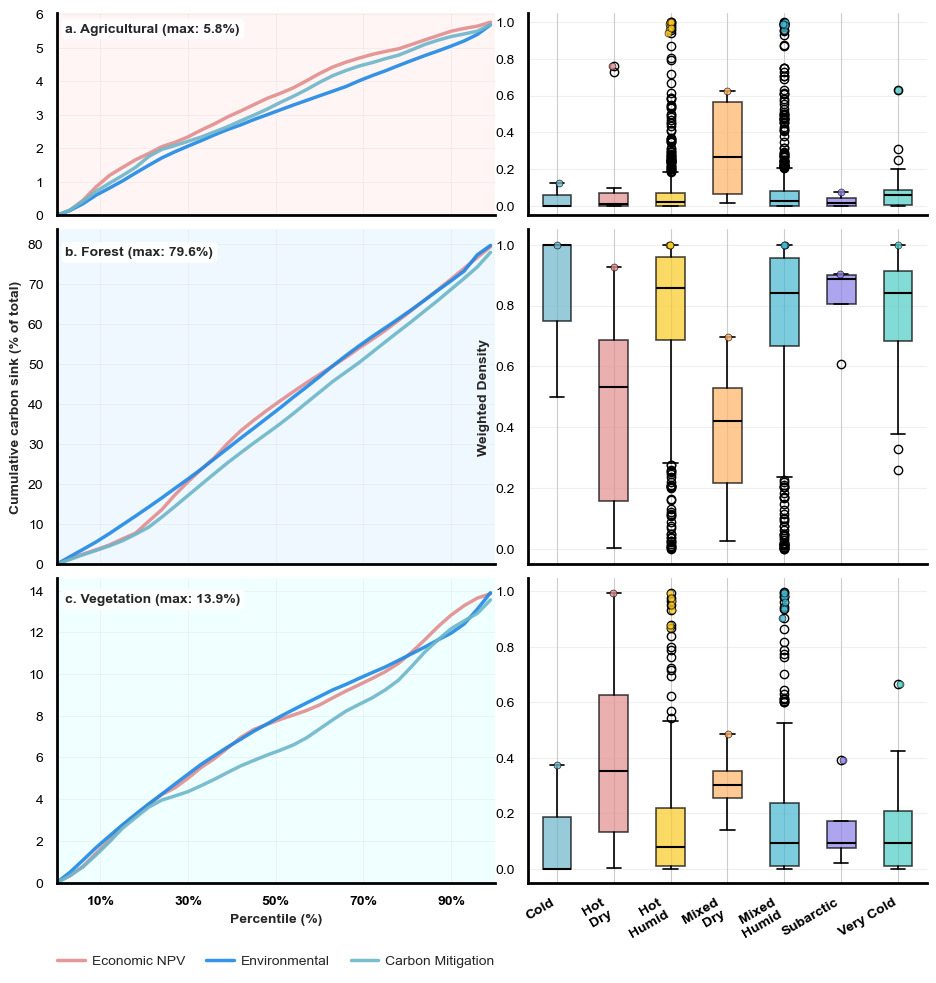

参照joint_distribution配色风格的气候区域分析图生成完成！


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from shapely.geometry import Point, box
from tqdm import tqdm
import geopandas as gpd
from matplotlib.gridspec import GridSpec

def percentile_square_layout_colored(pixel_optimized_data, df_net_benefit, df_weight, us_counties_4326,
                                    percentiles=np.arange(3,101,3),
                                    targets=(
                                             ('avg_npv','Economic NPV'),
                                             ('predicted_prob','Environmental'),
                                             ('Expectation_net_benefit','Carbon Mitigation'))):
    """
    正方形布局：参照joint_distribution的配色风格，确保10×10真正的正方形
    """
    
    # 定义美国大陆边界和气候区域数据
    usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)
    df_zone = pd.read_csv('data/US_data/df_zones.csv')
    
    # 裁剪县数据到美国大陆
    usa_mainland_box = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
                          usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    us_counties_4326_clipped = us_counties_4326.clip(usa_mainland_box)
    
    # 数据预处理
    m = (pixel_optimized_data
         .merge(df_net_benefit[['lat','lon','area_m2']], on=['lat','lon'], how='inner')
         .merge(df_weight[['lat','lon',
                           'final_forest','weighted_density_Forest',
                           'final_agro','weighted_density_Agricultural',
                           'final_veg','weighted_density_Vegetation']], on=['lat','lon'], how='inner'))
    
    # 计算县级密度统计并加入气候区域信息
    print("计算县级密度统计...")
    geometry = [Point(xy) for xy in zip(df_weight['lon'], df_weight['lat'])]
    df_weight_gdf = gpd.GeoDataFrame(df_weight, geometry=geometry, crs='EPSG:4326')
    us_counties_proj = us_counties_4326_clipped.to_crs('EPSG:4326')
    points_with_counties = gpd.sjoin(df_weight_gdf, us_counties_proj[['NAME', 'STATEFP', 'COUNTYFP', 'geometry']], 
                                    how='left', predicate='within')
    
    county_stats = []
    for county_name in tqdm(points_with_counties['NAME'].dropna().unique()):
        county_data = points_with_counties[points_with_counties['NAME'] == county_name]
        if len(county_data) > 0:
            countyfp = int(county_data['COUNTYFP'].iloc[0])
            # 匹配气候区域
            climate_info = df_zone[df_zone['County FIPS'] == countyfp]
            climate_zone = climate_info['BA Climate Zone'].iloc[0] if len(climate_info) > 0 else 'Unknown'
            
            county_info = {
                'county_name': county_name,
                'state': county_data['STATEFP'].iloc[0],
                'countyfp': countyfp,
                'climate_zone': climate_zone,
                'Agricultural': county_data['weighted_density_Agricultural'].mean(),
                'Vegetation': county_data['weighted_density_Vegetation'].mean(),
                'Forest': county_data['weighted_density_Forest'].mean()
            }
            county_stats.append(county_info)
    
    county_stats_df = pd.DataFrame(county_stats)
    # 移除Unknown气候区域的县
    county_stats_df = county_stats_df[county_stats_df['climate_zone'] != 'Unknown']
    
    # 碳汇计算
    ha = (m['area_m2'].values/10000.0)
    forest = m['final_forest'].values * m['weighted_density_Forest'].values * ha
    agro   = m['final_agro'].values   * m['weighted_density_Agricultural'].values * ha
    veg    = m['final_veg'].values    * m['weighted_density_Vegetation'].values * ha
    
    # 重新排序：Agricultural, Forest, Vegetation（Forest居中）
    sinks = [('Agricultural', agro, 'Agricultural'),
             ('Forest', forest, 'Forest'),
             ('Vegetation', veg, 'Vegetation')]

    # 采用joint_distribution的配色方案
    economic_color = '#E28D8D'  # 红色系，对应joint_distribution的X轴边际分布
    env_color = '#1E88E5'       # 蓝色，对应joint_distribution的主图
    carbon_color = '#6CB6C9'    # 青色系，对应joint_distribution的Y轴边际分布
    
    target_colors = [economic_color, env_color, carbon_color]
    
    # 背景颜色域 - 参照joint_distribution的配色风格
    background_colors = ['#FFF5F5', '#F0F8FF', '#F0FFFF']  # 淡红、淡蓝、淡青
    
    x = percentiles

    # 创建真正的正方形布局：强制正方形比例
    fig = plt.figure(figsize=(10, 10))
    fig.patch.set_facecolor('white')  # 设置背景为白色
    
    # 自定义网格比例：Forest高度增加10%
    height_ratios = [1, 1.65, 1.5]  # Forest从1.5增加到1.65（增加10%）
    gs = GridSpec(3, 2, figure=fig, 
                  width_ratios=[1.1, 1],  # 减少折线图比例，增加箱形图宽度
                  height_ratios=height_ratios,
                  hspace=0.05, wspace=0.08)  # 稍微增加间距
    
    legend_elements = []
    total = forest + agro + veg
    total_max = np.sum(total)
    max_percentages = []
    

    all_climate_zones = sorted(df_zone['BA Climate Zone'].unique())
    # 移除可能的空值
    all_climate_zones = [z for z in all_climate_zones if pd.notna(z)]
    
    # 为所有气候区域分配颜色 - 采用更深的颜色系，参考所给美国气候区分布图
    climate_colors = {
        'Marine':     '#2A6FA1',  # 深蓝色
        'Cold':       '#3B4A7A',  # 深靛蓝
        'Very Cold':  '#2C3E50',  # 极深蓝灰
        'Mixed-Humid':'#6A9A3A',  # 深绿色
        'Hot-Humid':  '#E89C1B',  # 深橙黄
        'Hot-Dry':    '#B85C2B',  # 深砖红
        'Mixed-Dry':  '#A05A2C',  # 深棕橙
        'Subarctic':  '#6C3483'   # 深紫色
    }
    axes_left = []
    
    for ax_idx, (sname, svals, density_type) in enumerate(sinks):
        # 左侧：累积效应图
        ax_left = fig.add_subplot(gs[ax_idx, 0])
        axes_left.append(ax_left)
        
        # 设置背景颜色
        ax_left.set_facecolor(background_colors[ax_idx])
        
        # 设置专业的坐标轴样式 - 参照joint_distribution
        ax_left.spines['top'].set_visible(False)
        ax_left.spines['right'].set_visible(False)
        ax_left.spines['bottom'].set_linewidth(2)
        ax_left.spines['left'].set_linewidth(2)
        ax_left.spines['bottom'].set_color('black')
        ax_left.spines['left'].set_color('black')
        
        all_y_values = []
        
        for ci, (tcol, tname) in enumerate(targets):
            order = np.argsort(m[tcol].values)[::-1]
            cum = np.cumsum(svals[order])
            
            cum_with_zero = np.concatenate([[0], cum])
            x_with_zero = np.concatenate([[0], x])
            
            y_values = []
            for p in x_with_zero:
                if p == 0:
                    y_values.append(0)
                else:
                    idx = int((p/100.0) * len(cum))
                    if idx < len(cum):
                        y_values.append(cum[idx])
                    else:
                        y_values.append(cum[-1])
            
            y = np.array(y_values) / total_max * 100
            all_y_values.extend(y)
            
            line = ax_left.plot(x_with_zero, y, lw=2.5, alpha=0.9, label=tname, 
                              color=target_colors[ci])
            
            if ax_idx == 0:
                legend_elements.append(line[0])

        max_y = max(all_y_values)
        max_percentages.append(max_y)
        y_max = max_y * 1.05
        ax_left.set_ylim(0, y_max)

        # X轴设置 - 统一字体大小和样式
        key_percentages = [10, 30, 50, 70, 90]
        ax_left.set_xticks(key_percentages)
        ax_left.set_xlim(0, 100)
        
        # 只在底部子图显示X轴标签
        if ax_idx == len(sinks) - 1:
            ax_left.set_xticklabels([f'{p}%' for p in key_percentages], ha='center', fontsize=10, fontweight='bold')
            ax_left.set_xlabel('Percentile (%)', fontsize=10, fontweight='bold')
        else:
            ax_left.set_xticklabels([])
        
        # 只在中间子图（Forest）显示Y轴标签
        if ax_idx == 1:  # Forest在中间
            ax_left.set_ylabel('Cumulative carbon sink (% of total)', fontsize=10, fontweight='bold')
        
        # 网格和刻度设置 - 统一样式
        ax_left.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
        ax_left.set_axisbelow(True)
        ax_left.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, 
                           color='black', labelcolor='black')
        
        # 折线图标题放在图形内部（贴着Y轴最上方）
        ax_left.text(0.02, 0.95, f'{chr(97+ax_idx)}. {sname} (max: {max_y:.1f}%)', 
                    transform=ax_left.transAxes, fontsize=10, fontweight='bold',
                    verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", 
                    facecolor="white", alpha=0.9, edgecolor='none'))

        # 右侧：按气候区域分组的密度箱线图
        ax_right = fig.add_subplot(gs[ax_idx, 1])
        
        # 获取在县级数据中存在的气候区域
        available_climates = sorted(county_stats_df['climate_zone'].unique())
        
        density_by_climate = []
        climate_labels = []
        colors_for_boxes = []
        
        for climate in available_climates:
            climate_data = county_stats_df[county_stats_df['climate_zone'] == climate]
            if len(climate_data) > 0:
                density_values = climate_data[density_type].values
                density_by_climate.append(density_values)
                # 缩短标签
                short_label = climate.replace('-', '\n')  # 换行显示
                climate_labels.append(short_label)
                colors_for_boxes.append(climate_colors.get(climate, '#CCCCCC'))
        
        # 创建按气候区域分组的箱线图
        if density_by_climate:
            box_parts = ax_right.boxplot(density_by_climate, patch_artist=True,
                                        boxprops=dict(alpha=0.7, linewidth=1.2),
                                        medianprops=dict(color='black', linewidth=1.5),
                                        whiskerprops=dict(linewidth=1.2),
                                        capprops=dict(linewidth=1.2))
            
            # 设置每个气候区域的颜色
            for patch, color in zip(box_parts['boxes'], colors_for_boxes):
                patch.set_facecolor(color)
            
            # 添加散点显示高值
            for i, (data, color) in enumerate(zip(density_by_climate, colors_for_boxes)):
                q3 = np.percentile(data, 75)
                q99 = np.percentile(data, 99)
                
                high_values_mask = data > q99
                high_values = data[high_values_mask]
                
                if len(high_values) > 0:
                    x_positions = np.random.normal(i+1, 0.02, len(high_values))
                    ax_right.scatter(x_positions, high_values, alpha=0.8, s=25, 
                                   color=color, edgecolors='black', linewidth=0.5, zorder=10)
        
        # 设置右侧子图样式 - 统一字体样式
        ax_right.spines['top'].set_visible(False)
        ax_right.spines['right'].set_visible(False)
        ax_right.spines['bottom'].set_linewidth(2)
        ax_right.spines['left'].set_linewidth(2)
        ax_right.spines['bottom'].set_color('black')
        ax_right.spines['left'].set_color('black')
        ax_right.tick_params(axis='both', which='major', width=2, size=6, labelsize=10, 
                           color='black', labelcolor='black')
        ax_right.grid(True, alpha=0.3, axis='y')
        
        ax_right.set_xticks(range(1, len(climate_labels)+1))
        
        # 只在底部显示X轴标签 - 稍微倾斜
        if ax_idx == len(sinks) - 1:
            ax_right.set_xticklabels(climate_labels, fontsize=10, fontweight='bold', 
                                   rotation=30, ha='right')  
        else:
            ax_right.set_xticklabels([])
        
        # 只在中间图显示Y轴标签
        if ax_idx == 1:  # Forest在中间
            ax_right.set_ylabel('Weighted Density', fontsize=10, fontweight='bold')
        
        # 不显示任何箱形图标题

    # 为每个折线图单独添加图例，放在折线图的最下方
    for ax_idx, ax_left in enumerate(axes_left):
        if ax_idx == len(sinks) - 1:  # 只在最后一个图显示图例
            ax_left.legend(handles=legend_elements, loc='lower center', 
                         bbox_to_anchor=(0.5, -0.32), ncol=3, fontsize=10, 
                         frameon=False, columnspacing=1.5, handletextpad=0.5)

    # 去掉整体标题以节约空间
    
    plt.tight_layout()
    # 调整边距确保是正方形
    plt.subplots_adjust(bottom=0.08, top=0.95, left=0.08, right=0.95)
    
    # 强制设置图形为正方形
    fig.set_size_inches(10, 10, forward=True)
    
    print("\n=== 各碳汇类型最大累积百分比 ===")
    for i, (sname, _, _) in enumerate(sinks):
        print(f"{sname}: {max_percentages[i]:.1f}%")
    
    print("\n=== 配色风格说明 ===")
    print("- Economic NPV: #E28D8D (红色系，对应joint_distribution的X轴边际分布)")
    print("- Environmental: #1E88E5 (蓝色，对应joint_distribution的主图)")
    print("- Carbon Mitigation: #6CB6C9 (青色系，对应joint_distribution的Y轴边际分布)")
    print("- 气候区域颜色也参照joint_distribution的配色风格")
    
    return fig, county_stats_df

# 执行函数
fig_colored, county_stats_df = percentile_square_layout_colored(
    df_pixel_optimized_data, df_net_benefit, df_weight, us_counties_4326)

# 保存图片
fig_colored.savefig("figure/US_figure/colored_cumulative_climate_density.png", 
                   dpi=300, bbox_inches='tight', facecolor='white')
fig_colored.savefig("figure/US_figure/colored_cumulative_climate_density.eps", 
                   bbox_inches='tight', format='eps')

plt.show()
print("参照joint_distribution配色风格的气候区域分析图生成完成！")

## 3.3 图3经济折线图

In [89]:
df_economic

lat         lon pv_category      pv_model  \
0         31.320833 -105.929170          C1    REMIND 2.1   
1         31.329166 -105.929170          C1    REMIND 2.1   
2         31.337500 -105.937500          C1    REMIND 2.1   
3         31.337500 -105.929170          C1    REMIND 2.1   
4         31.345833 -105.937500          C1    REMIND 2.1   
...             ...         ...         ...           ...   
68880915  46.937500  -67.920830          C7  TIAM-ECN 1.1   
68880916  47.145832  -67.962500          C7  TIAM-ECN 1.1   
68880917  47.237500  -68.620834          C7  TIAM-ECN 1.1   
68880918  47.254166  -68.354164          C7  TIAM-ECN 1.1   
68880919  47.262500  -68.379166          C7  TIAM-ECN 1.1   

                   pv_scenario policy_category rcp_category   net_npv_usd  \
0         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364320e+06   
1         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364268e+06   
2         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364232e+06   
3         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364223e+06   
4         CEMICS_GDPgrowth_1p5             P2a       RCP2.6 -2.364196e+06   
...                        ...             ...          ...           ...   
68880915        EN_NPi2100_COV             P1b       RCP8.5  4.447125e+06   
68880916        EN_NPi2100_COV             P1b       RCP8.5  4.148731e+06   
68880917        EN_NPi2100_COV             P1b       RCP8.5  4.294753e+06   
68880918        EN_NPi2100_COV             P1b       RCP8.5  4.331141e+06   
68880919        EN_NPi2100_COV             P1b       RCP8.5  4.147186e+06   

          net_cost_usd  analysis_year policy_group  
0         2.364320e+06           2020           P2  
1         2.364268e+06           2020           P2  
2         2.364232e+06           2020           P2  
3         2.364223e+06           2020           P2  
4         2.364196e+06           2020           P2  
...                ...            ...          ...  
68880915  4.654054e+06           2050           P1  
68880916  4.654008e+06           2050           P1  
68880917  4.654032e+06           2050           P1  
68880918  4.654020e+06           2050           P1  
68880919  4.654010e+06           2050           P1  

[68880920 rows x 11 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


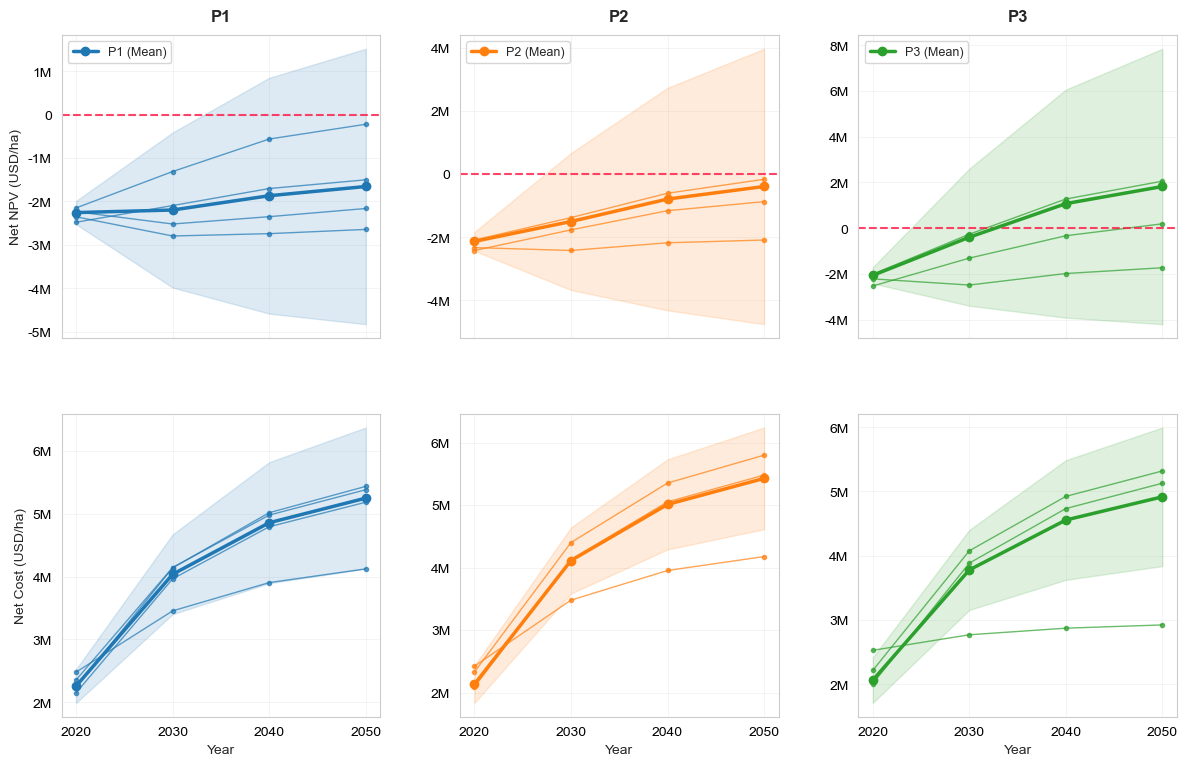

政策情景分析图（含net_npv_usd和net_cost_usd）创建完成！


In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def create_policy_scenarios_analysis(df_economic):
    """
    创建P1-P3政策情景分析图，分别展示net_npv_usd和net_cost_usd的演化趋势
    布局：2行3列，行对应指标（上：net_npv_usd，下：net_cost_usd），列对应P1-P3政策情景
    """
    
    # 按照policy_category中含有的字符串P1,P2,P3进行匹配分配
    def match_policy(row):
        if 'P1' in str(row):
            return 'P1'
        elif 'P2' in str(row):
            return 'P2'
        elif 'P3' in str(row):
            return 'P3'
        else:
            return 'Other'

    df_economic['policy_group'] = df_economic['policy_category'].astype(str).apply(match_policy)
    
    # 筛选出P1-P3的数据
    df_filtered = df_economic[df_economic['policy_group'].isin(['P1', 'P2', 'P3'])]
    
    # 获取年份和指标
    years = sorted(df_filtered['analysis_year'].unique())
    policy_groups = ['P1', 'P2', 'P3']
    metrics = ['net_npv_usd', 'net_cost_usd']  # 展示两个指标
    
    # 创建2行3列的布局
    fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True)
    
    # 精准提取图片的颜色方案
    colors = {
        'P1': '#1f77b4',  # 蓝色 (对应图片中的Tier 1)
        'P2': '#ff7f0e',  # 橙色 (对应图片中的Tier 1 + 2)
        'P3': '#2ca02c',  # 绿色 (对应图片中的Tier 1 + 2 + 3)
    }
    
    # 绘制每个子图
    for i, metric in enumerate(metrics):
        for j, policy in enumerate(policy_groups):
            ax = axes[i, j]
            
            # 获取当前政策组的数据
            group_data = df_filtered[df_filtered['policy_group'] == policy]
            
            if len(group_data) > 0:
                # 获取该政策组下的所有唯一policy_category
                unique_policies = group_data['policy_category'].unique()
                
                # 为每个具体的policy_category绘制一条曲线
                for policy_cat in unique_policies:
                    if pd.notna(policy_cat) and policy_cat != 'nan':
                        # 获取特定policy_category的数据
                        specific_data = group_data[group_data['policy_category'] == policy_cat]
                        
                        if len(specific_data) > 0:
                            # 按年份分组，计算均值
                            mean_by_year = specific_data.groupby('analysis_year')[metric].mean().reset_index()
                            
                            # 绘制每条具体政策的曲线（细线）
                            ax.plot(mean_by_year['analysis_year'], mean_by_year[metric], 
                                   color=colors[policy], linewidth=1, marker='o', 
                                   markersize=3, alpha=0.7, zorder=2)
                
                # 计算并绘制总体均值和标准差
                stats_by_year = group_data.groupby('analysis_year')[metric].agg(['mean', 'std']).reset_index()
                
                # 绘制总体均值线（粗线，高亮显示）
                ax.plot(stats_by_year['analysis_year'], stats_by_year['mean'], 
                       color=colors[policy], linewidth=2.5, marker='o', 
                       markersize=6, label=f'{policy} (Mean)', zorder=3)
                
                # 绘制总体标准差区间（浅色填充）
                if len(stats_by_year) > 1:
                    ax.fill_between(stats_by_year['analysis_year'], 
                                  stats_by_year['mean'] - stats_by_year['std'],
                                  stats_by_year['mean'] + stats_by_year['std'],
                                  color=colors[policy], alpha=0.15, zorder=1)
                
                # 设置标题和标签
                if i == 0:
                    ax.set_title(f'{policy}', fontsize=12, fontweight='bold', pad=10)
                if j == 0:  # 第一列
                    ylabel = 'Net NPV (USD/ha)' if metric == 'net_npv_usd' else 'Net Cost (USD/ha)'
                    ax.set_ylabel(ylabel, fontsize=10)
                
                # 设置X轴标签
                if i == 1:
                    ax.set_xlabel('Year', fontsize=10)
                
                # 设置网格
                ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5, zorder=0)
                ax.set_axisbelow(True)
                
                # 设置刻度标签大小和颜色为黑色
                ax.tick_params(axis='both', which='major', labelsize=10, colors='black')
                
                # 设置X轴刻度
                ax.set_xticks(years)
                ax.set_xticklabels(years, rotation=0, color='black')
                # 特殊处理NPV的Y=0线
                if metric == 'net_npv_usd':
                    ax.axhline(y=0, color='#FF1744', linestyle='--', linewidth=1.5, alpha=0.8, zorder=2)
                
                # 设置Y轴格式
                def custom_y_formatter(x, pos):
                    if abs(x) >= 1e9:
                        return f'{x/1e9:.1f}B'
                    elif abs(x) >= 1e6:
                        return f'{x/1e6:.0f}M'
                    else:
                        return f'{x:.0f}'
                ax.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))
                
                # 添加图例
                if i == 0:
                    ax.legend(fontsize=9, loc='upper left')
            else:
                # 如果没有数据，显示提示信息
                ax.text(0.5, 0.5, f'No data for {policy}', 
                       ha='center', va='center', transform=ax.transAxes, fontsize=10)
                if i == 0:
                    ax.set_title(f'{policy}', fontsize=12, fontweight='bold', pad=10)
    
    # # 设置整体标题
    # fig.suptitle('Policy Scenarios Analysis: Net NPV & Net Cost Evolution (2020-2050)', 
    #              fontsize=14, fontweight='bold', y=0.98)
    
    # 调整布局
    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.25, wspace=0.25)
    
    return fig, axes

# 使用示例
fig_policy, axes_policy = create_policy_scenarios_analysis(df_economic)

# 保存图片
fig_policy.savefig('figure/US_figure/Figure_policy_scenarios_analysis.eps', 
                   bbox_inches='tight', dpi=300, format='eps')
fig_policy.savefig('figure/US_figure/Figure_policy_scenarios_analysis.png', 
                   bbox_inches='tight', dpi=300, format='png')

plt.show()

print("政策情景分析图（含net_npv_usd和net_cost_usd）创建完成！")